<a href="https://colab.research.google.com/github/chipkkang9/adversarial-attack/blob/master/Executing_White_box_Attack_on_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# White-box Attack on CIFAR10

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json

import torch
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms

def get_imagenet_data():
    MEAN = [0.485, 0.456, 0.406]
    STD = [0.229, 0.224, 0.225]
    # https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
    class_idx = json.load(open("./data/imagenet_class_index.json"))
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
        transforms.Normalize(mean=MEAN, std=STD)
    ])
    imagnet_data = image_folder_custom_label(root='./data/imagenet',
                                             transform=transform,
                                             idx2label=idx2label)
    data_loader = torch.utils.data.DataLoader(imagnet_data, batch_size=1, shuffle=False)
    print("Used normalization: mean=", MEAN, "std=", STD)
    return iter(data_loader).next()

def get_pred(model, images, device):
    logits = model(images.to(device))
    _, pres = logits.max(dim=1)
    return pres.cpu()

def imshow(img, title):
    img = torchvision.utils.make_grid(img.cpu().data, normalize=True)
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

def image_folder_custom_label(root, transform, idx2label) :
    # custom_label
    # type : List
    # index -> label
    # ex) ['tench', 'goldfish', 'great_white_shark', 'tiger_shark']

    old_data = dsets.ImageFolder(root=root, transform=transform)
    old_classes = old_data.classes

    label2idx = {}

    for i, item in enumerate(idx2label) :
        label2idx[item] = i

    new_data = dsets.ImageFolder(root=root, transform=transform,
                                 target_transform=lambda x : idx2label.index(old_classes[x]))
    new_data.classes = idx2label
    new_data.class_to_idx = label2idx

    return new_data


def l2_distance(model, images, adv_images, labels, device="cuda"):
    outputs = model(adv_images)
    _, pre = torch.max(outputs.data, 1)
    corrects = (labels.to(device) == pre)
    delta = (adv_images - images.to(device)).view(len(images), -1)
    l2 = torch.norm(delta[~corrects], p=2, dim=1).mean()
    return l2

In [ ]:
#colab 상의 No GPU 문제 해결을 위한 cuda 설치
# os.environ["CUDA_VISIBLE_DEVICES"]
!apt-get --purge remove cuda nvidia* libnvidia-*
!dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
!apt-get remove cuda-*
!apt autoremove

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'nvidia-kernel-common-418-server' for glob 'nvidia*'
Note, selecting 'nvidia-325-updates' for glob 'nvidia*'
Note, selecting 'nvidia-346-updates' for glob 'nvidia*'
Note, selecting 'nvidia-driver-binary' for glob 'nvidia*'
Note, selecting 'nvidia-331-dev' for glob 'nvidia*'
Note, selecting 'nvidia-compute-utils-418-server' for glob 'nvidia*'
Note, selecting 'nvidia-384-dev' for glob 'nvidia*'
Note, selecting 'nvidia-docker2' for glob 'nvidia*'
Note, selecting 'nvidia-headless-525-server' for glob 'nvidia*'
Note, selecting 'nvidia-headless-530-open' for glob 'nvidia*'
Note, selecting 'nvidia-fs-prebuilt' for glob 'nvidia*'
Note, selecting 'nvidia-driver-530-open' for glob 'nvidia*'
Note, selecting 'nvidia-driver-440-server' for glob 'nvidia*'
Note, selecting 'nvidia-dkms-450-server' for glob 'nvidia*'
Note, selecting 'nvidia-headless-no-dkms-515-open' for glob 'nvidia*'
Note, 

In [ ]:

!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-repo-ubuntu1804_10.0.130-1_amd64.deb
!sudo dpkg -i cuda-repo-ubuntu1804_10.0.130-1_amd64.deb
!sudo apt-key adv --fetch-keys https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/7fa2af80.pub
!sudo apt-get update
!wget http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb
!sudo apt install -y ./nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb
!sudo apt-get update

# Install NVIDIA driver
#!sudo apt-get install --no-install-recommends nvidia-driver-418
!sudo apt-get -y installnvidia-driver-418
# Reboot. Check that GPUs are visible using the command: nvidia-smi

# Install development and runtime libraries (~4GB)
#!sudo apt-get install --no-install-recommends \
!sudo apt-get install -y \
    cuda-10-0 \
    libcudnn7=7.6.2.24-1+cuda10.0  \
    libcudnn7-dev=7.6.2.24-1+cuda10.0


# Install TensorRT. Requires that libcudnn7 is installed above.
# !sudo apt-get install -y --no-install-recommends libnvinfer5=5.1.5-1+cuda10.0 \
!sudo apt-get install -y libnvinfer5=5.1.5-1+cuda10.0 \
    libnvinfer-dev=5.1.5-1+cuda10.0

!apt --fix-broken install

--2023-07-06 05:44:16--  https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-repo-ubuntu1804_10.0.130-1_amd64.deb
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.199.39.144
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.199.39.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2942 (2.9K) [application/x-deb]
Saving to: ‘cuda-repo-ubuntu1804_10.0.130-1_amd64.deb’

cuda-repo-ubuntu180 100%[===================>]   2.87K  --.-KB/s    in 0s      

2023-07-06 05:44:16 (194 MB/s) - ‘cuda-repo-ubuntu1804_10.0.130-1_amd64.deb’ saved [2942/2942]

Selecting previously unselected package cuda-repo-ubuntu1804.
(Reading database ... 121415 files and directories currently installed.)
Preparing to unpack cuda-repo-ubuntu1804_10.0.130-1_amd64.deb ...
Unpacking cuda-repo-ubuntu1804 (10.0.130-1) ...
Setting up cuda-repo-ubuntu1804 (10.0.130-1) ...

Configuration file '/etc/apt/sources.li

In [ ]:
pip install torchattacks

In [ ]:
import sys

import torch
import torch.nn as nn

sys.path.insert(0, '..')
import torchattacks

## Load model and data

In [ ]:
sys.path.insert(0, '..')
import robustbench
from robustbench.data import load_cifar100
from robustbench.utils import load_model, clean_accuracy

images, labels = load_cifar10(n_examples=5)
print('[Data loaded]')

device = "cuda"
model = load_model('Standard', norm='Linf').to(device)
acc = clean_accuracy(model, images.to(device), labels.to(device))
print('[Model loaded]')
print('Acc: %2.2f %%'%(acc*100))

Files already downloaded and verified
[Data loaded]
[Model loaded]
Acc: 100.00 %


## Adversarial Attack

In [ ]:
!install pip
!pip install torchattacks
!sudo pip install jupyter_utils
from torchattacks import PGD
#from utils import imshow, get_pred

install: missing destination file operand after 'pip'
Try 'install --help' for more information.


In [ ]:
atk = PGD(model, eps=1/255, alpha=2/225, steps=10, random_start=True)
print(atk)

PGD(model_name=WideResNet, device=cuda:0, attack_mode=default, targeted=False, normalization_used=False, eps=0.00392156862745098, alpha=0.008888888888888889, steps=10, random_start=True)


In [ ]:
# When normalization used:
# atk.set_normalization_used(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [ ]:
adv_images = atk(images, labels)

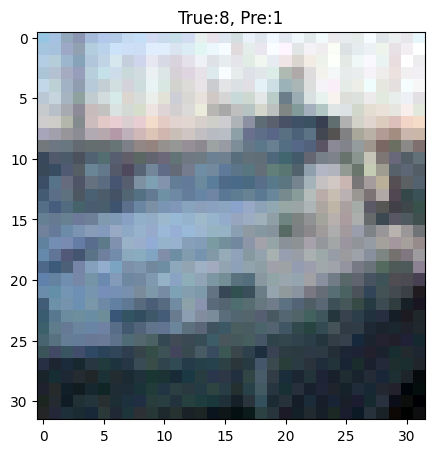

In [ ]:
idx = 0
pre = get_pred(model, adv_images[idx+2:idx+3], device)
imshow(adv_images[idx+2:idx+3], title="True:%d, Pre:%d"%(labels[idx+2], pre))